In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numba

In [2]:
import pandas as pd
import numpy as np
import quantstats as qs
qs.extend_pandas()

%matplotlib inline
import matplotlib.pyplot as plt
pd.options.display.max_rows = 99999

import warnings
warnings.filterwarnings("ignore")

def close_position(path,commento):
    
    import pymt5adapter as mta
    from pymt5adapter.order import  Order
    mta.initialize(path)
    posizione_aperte = mta.positions_get()

    for pos in posizione_aperte:
        if commento == pos.comment:
            close_order = Order.as_flatten(pos,type_filling=1)
            close_order.send()
            print(pos)

def report(tradelist,initial_capital,type_analisy,Benchmark):
    %matplotlib inline
    import quantstats as qs
    qs.extend_pandas()

    tradelist = tradelist.fillna(0)
    tradelist = tradelist[tradelist!=0]
    tradelist.iloc[0] = tradelist.iloc[0]+initial_capital
    tradelist = tradelist.cumsum()
    
    if type_analisy == 0:
        qs.plots.snapshot(tradelist)
    if type_analisy == 1:    
        if len(Benchmark)>0:
            qs.reports.basic(tradelist,Benchmark)
        else:
            qs.reports.basic(tradelist)
    if type_analisy == 2:    
        if len(Benchmark)>0:
            qs.reports.full(tradelist,Benchmark)
        else:
            qs.reports.full(tradelist)

def allsymbols(path):
    import MetaTrader5 as mt5
    if not mt5.initialize(path):
        print("initialize() failed, error code =",mt5.last_error())
        quit()

    allsymbol=[]
    symbols=mt5.symbols_get()
    count=0
    for s in symbols:
        count+=1
        allsymbol.append(s.name)
    return allsymbol

def readdata(market,tf,barre,path):
    from datetime import datetime
    import MetaTrader5 as mt5
    import pandas as pd

    if not mt5.initialize(path):
        print("initialize() failed, error code =",mt5.last_error())
        quit()
    
    mk=str(market)
    TF="mt5.TIMEFRAME_"+str(tf)
    bar=barre
    
    cnt=0
    salta=0
    while True:
        cnt=cnt+1
        try:
            rates = mt5.copy_rates_from_pos(mk, eval(TF), 0, bar) #1700
            if len(rates)>0:
                break
        except:
            if cnt<2:
                continue
            else:
                salta=1
                break
    if salta == 0:
        rates_frame = pd.DataFrame(rates)
        rates_frame['time']=pd.to_datetime(rates_frame['time'], unit='s')
        rates_frame=rates_frame[["time","open","high","low","close","tick_volume"]]
        rates_frame.columns=(["time","open","high","low","close","volume"])
        rates_frame=rates_frame.set_index(["time"])
        rates_frame=rates_frame[(rates_frame.T != 0).any()]
        return rates_frame
    else:
        return pd.DataFrame()
    
def get_poin_values(path,simb):

    import MetaTrader5 as mt5
    if not mt5.initialize(path):
        print("initialize() failed, error code =",mt5.last_error())
        quit()
    symbol_info=mt5.symbol_info(simb)
    if symbol_info!=None:
        symbol_info_dict = mt5.symbol_info(simb)._asdict()
    mt5.shutdown()    
    tmp=symbol_info_dict['trade_tick_value']/symbol_info_dict['point']
    return tmp

def ordine_market(mercato,quantita,deviazione,path,direzione,commento):
    import time
    import pymt5adapter as mta
    from pymt5adapter.order import  Order
    
    mta.initialize(path)
    status=0
    if direzione == "long":
    
        order = Order.as_buy(symbol=mercato , 
                              volume=float(quantita),
                              #magic=int(magic),
                              type_filling=1,
                              #tp=float(target),
                              #sl=float(stop),
                              deviation=deviazione,
                              comment=commento)
    
    if direzione == "short":
    
        order = Order.as_sell(symbol=mercato , 
                              volume=float(quantita),
                              #magic=int(magic),
                              type_filling=1,
                              #tp=float(target),
                              #sl=float(stop),
                              deviation=deviazione,
                              comment=commento)
    while True: 
        r = order.send()
        time.sleep(1)
        if r[7]=='Request executed':
            print(r,'Request executed')
            status=1
            break
        if r[7]=="Market closed":
            print(r[7],"Market closed")
            status=0
            break
    return status

def check_start_sessiona(path,simbolo):
    x=readdata(simbolo,"M1",3000,path)
    y=list(set(x.index.hour))
    y.sort()
    z=x.index.minute[x.index.hour==y[0]]
    z=list(set(z))
    z.sort()
    return y[0],z[0]

def check_end_sessiona(path,simbolo):
    x=readdata(simbolo,"M1",3000,path)
    y=list(set(x.index.hour))
    y.sort()
    z=x.index.minute[x.index.hour==y[-1]]
    z=list(set(z))
    z.sort()
    return y[-1],z[-1]

def get_spread(path,simbolo):
    import MetaTrader5 as mt5

    if not mt5.initialize(path):
        print("initialize() failed, error code =",mt5.last_error())
        quit()

    symbol_info=mt5.symbol_info(simbolo)
    try:
        if len(symbol_info)>0:
            return symbol_info.spread
    except:
        return None
    
def get_category(path,simb):
    import MetaTrader5 as mt5
    if not mt5.initialize(path):
        print("initialize() failed, error code =",mt5.last_error())
        quit()
    symbol_info=mt5.symbol_info(simb)
    if symbol_info!=None:
        symbol_info_dict = mt5.symbol_info(simb)._asdict()
    mt5.shutdown()    
    return symbol_info_dict['path']

def get_ETF(path,simb):
    import MetaTrader5 as mt5
    if not mt5.initialize(path):
        print("initialize() failed, error code =",mt5.last_error())
        quit()
    symbol_info=mt5.symbol_info(simb)
    if symbol_info!=None:
        symbol_info_dict = mt5.symbol_info(simb)._asdict()
    mt5.shutdown()    
    return symbol_info_dict['description']
    
    
def get_min_contract(path,simbolo):
    import MetaTrader5 as mt5

    if not mt5.initialize(path):
        print("initialize() failed, error code =",mt5.last_error())
        quit()

    symbol_info=mt5.symbol_info(simbolo)
    return symbol_info.volume_min

def get_max_contract(path,simbolo):
    import MetaTrader5 as mt5

    if not mt5.initialize(path):
        print("initialize() failed, error code =",mt5.last_error())
        quit()

    symbol_info=mt5.symbol_info(simbolo)
    return symbol_info.volume_max

def close_all_position(path):
    
    import pymt5adapter as mta
    from pymt5adapter.order import  Order
    mta.initialize(path)
    posizione_aperte = mta.positions_get()

    for pos in posizione_aperte:
        close_order = Order.as_flatten(pos,type_filling=1)
        close_order.send()
        print(pos)
        
def remove_outlier(y):
    Q1 = np.percentile(y, 20, #25
                       interpolation = 'midpoint')
    Q3 = np.percentile(y, 80, #75
                       interpolation = 'midpoint')
    IQR = Q3 - Q1
    y[y>=Q3+1.5*IQR]=0
    y[y<=Q1-1.5*IQR]=0
    return y

def gross_profit(operations):
    return round(operations[operations > 0].sum(),2)
    
def gross_loss(operations):
    return round(operations[operations <= 0].sum(),2)
    
def profit_factor(operations):
    a = gross_profit(operations)
    b = gross_loss(operations)
    if b != 0:
        return round(abs(a / b), 2)
    else:
        return round(abs(a / 0.00000001), 2)
    
def kestner_ratio(operations):

    import numpy as np
    import matplotlib.pyplot as plt 
    from scipy import stats
    
    monthly_operations = operations.resample('D').sum().fillna(0)
    monthly_equity = monthly_operations.cumsum()
    index = np.array(np.arange(1,monthly_operations.count() + 1))
    
    x = index
    y = monthly_equity
    gradient, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    
    if std_err != 0 and len(index) > 0:
        return round(gradient / (std_err * len(index)),5)
    else:
        return np.inf
    
def avg_trade(operations):
    return round(operations.mean(),2)

def check_position(path,commento):
    
    import pymt5adapter as mta
    from pymt5adapter.order import  Order
    mta.initialize(path)
    posizione_aperte = mta.positions_get()
    check = False
    for pos in posizione_aperte:
        if commento == pos.comment:
            check = True
    return check

In [3]:
%run ./Genetic_Lib.ipynb

In [4]:
def strategy_to_neptune_open_balance(simbolo,strategia,bigpointvalue,path,start_test,end_test,costi):

    df=strategia.copy()
    df["exit_time"]=df.index
    tmp_direzione=df["direzione"].iloc[0]

    utc_data=readdata_MT5_Date(simbolo,"M5",path,start_test,end_test)

    utc_data["open_trade"]=0

    if tmp_direzione == "long":
        dz=1

    if tmp_direzione == "short":
        dz=-1

    for e in range(len(df)):
        trade = utc_data.open.loc[df["entry_time"].iloc[e]:df["exit_time"].iloc[e]]
        trade = trade.shift(-1)-trade
        trade = trade.fillna(0)
        trade = trade * dz * bigpointvalue
        tmp_costi = costi/len(trade)
        trade = trade - tmp_costi
        utc_data.open_trade.loc[df["entry_time"].iloc[e]:df["exit_time"].iloc[e]]=trade
        
    return  utc_data.open_trade

In [5]:
import talib as ta 
import time

def level_to_condition(enter_level,history,tipo_ordine,direzione):
    enter_level=eval(enter_level)
    history["level_check"] = [True]*len(enter_level)
    if (tipo_ordine == "stop") | (tipo_ordine == "limit"):
        if (direzione == "long") & (tipo_ordine == "stop"):  
            history["level_check"] = (history.high >= enter_level)
        if (direzione == "short") & (tipo_ordine == "stop"):    
            history["level_check"] = (history.low <= enter_level)
        if (direzione == "long") & (tipo_ordine == "limit"):  
            history["level_check"] = (history.low <= enter_level)
        if (direzione == "short") & (tipo_ordine == "limit"):    
            history["level_check"] = (history.high >= enter_level)

    return history["level_check"]

def check_stoploss(SL,history,enter_level,BIGPOINTVALUE,direzione):

    if (SL != 0) & (direzione == "long") :
        return ((history.close - enter_level) * BIGPOINTVALUE) <= -SL
    if (SL != 0) & (direzione == "short") :
        return ((enter_level - history.close ) * BIGPOINTVALUE) <= -SL
    else:
        return [False]*len(history)
    
def check_takeprofit(TP,history,enter_level,BIGPOINTVALUE,direzione):

    if (TP != 0) & (direzione == "long"):
        return ((history.close - enter_level) * BIGPOINTVALUE) >= TP
    if (TP != 0) & (direzione == "short"):
        return ((enter_level - history.close) * BIGPOINTVALUE) >= TP
    else:
        return [False]*len(history)    
    
def check_add_rule(ADD_RULE_CONDITION,history):
    if str(ADD_RULE_CONDITION) == "False":
        return np.array([True]*len(history.iloc[:,0]))
    else:
        history["add_rule_check"]=eval(ADD_RULE_CONDITION)
        return np.array(history["add_rule_check"])

def BK_Plus(history,direzione,entry_rule,exit_rule,bigpointvalue,tick,level,tipo_ordine,exit_bars,TP,SL,costi,ADD_RULE_CONDITION):

    entry = np.array(np.array(eval(entry_rule)) & np.array(level_to_condition(level,history,tipo_ordine,direzione)) & check_add_rule(ADD_RULE_CONDITION,history))
    loss = np.array(check_stoploss(SL,history,eval(level),bigpointvalue,direzione))
    gain = np.array(check_takeprofit(TP,history,eval(level),bigpointvalue,direzione))
    if exit_rule != "False":
        exit_rule = np.array(eval(exit_rule))
    else:
        exit_rule = np.array([False]*len(entry))   
        
    price = np.array(history.open)
    index_date = np.array(history.index)


    #start = time.time()
    big_ls=[]
    MP = 0
    salta = 0
    while True:
        if exit_bars == 0:
            exit_bars = 999999999
        ingresso = np.where(entry==True)[0]  
        if ingresso.size >0:
            ingresso=ingresso[0]+1
            uscita_a_barre = ingresso+exit_bars

            uscita_a_loss = np.where(loss==True)[0] 
            uscita_a_loss = uscita_a_loss[uscita_a_loss>=ingresso]
            if uscita_a_loss.size == 0:
                uscita_a_loss = 999999999
            else:
                uscita_a_loss = uscita_a_loss[0]+1

            uscita_a_gain = np.where(gain==True)[0]
            uscita_a_gain = uscita_a_gain[uscita_a_gain>=ingresso]
            if uscita_a_gain.size == 0:
                uscita_a_gain = 999999999
            else:
                uscita_a_gain = uscita_a_gain[0]+1

            uscita_a_rule = np.where(exit_rule==True)[0]
            uscita_a_rule = uscita_a_rule[uscita_a_rule>=ingresso]
            if uscita_a_rule.size == 0:
                uscita_a_rule = 999999999
            else:
                uscita_a_rule = uscita_a_rule[0]+1    

            first_exit = np.sort([uscita_a_barre,uscita_a_loss,uscita_a_gain,uscita_a_rule])[0]
            if price.size-1 < first_exit:  ####
                first_exit = price.size-1
                MP = 1
                
                if first_exit == ingresso-1:
                    #print("salta")
                    ingresso = ingresso-1
                    salta = 1
            if salta == 0:
                operation = ((price[first_exit]-price[ingresso])*bigpointvalue)

                if direzione == "short":
                    operation=operation*(-1)
                    operation=operation-costi
                else:
                    operation=operation-costi

                index_start = index_date[ingresso]
                index_exit = index_date[first_exit]
                big_ls.append([index_start,index_exit,price[ingresso],price[first_exit],np.round_(operation, decimals=2),MP])

                entry = entry[first_exit:]
                loss = loss[first_exit:]
                gain = gain[first_exit:]
                exit_rule = exit_rule[first_exit:]
                price = price[first_exit:]
                index_date = index_date[first_exit:]
        else:
            break
        if MP == 1:
            break

    end = time.time()
    #print("Backtest strategia ..." , end - start)

    if len(big_ls)>0:
        op=pd.DataFrame(big_ls)
        op.columns=(["entry_time","exit_time","prezzo_ingresso","prezzo_uscita","operations","MP"])
        op["direzione"]=direzione
        op.set_index(["exit_time"],inplace=True)
        op.index=pd.to_datetime(op.index)
        return op
    else:
        return pd.DataFrame(columns=(["entry_time","exit_time","prezzo_ingresso","prezzo_uscita","operations","MP"]))

In [128]:
import datetime
from datetime import timedelta
import time
import os




test_ls=[]

files = os.listdir(r"C:\Users\Administrator\fAInance\Strategy_2")
os.chdir(r"C:\Users\Administrator\fAInance\Strategy_2")


clear_output(wait=True)
now = str((datetime.datetime.now()+timedelta(days=2)).date())
print(now)
MP_Live = []
DF = pd.DataFrame()
df_spread = pd.DataFrame()
salta=0

for E in tqdm(files):

    tmp_MP_Live = []

    System = pd.read_csv(E)
    System.set_index(["Unnamed: 0"],inplace=True)

    simbolo = System.file_name[0]
    time_frame = System.resample_tf[0]

    TP_ptf = int(System["ptf_TP"][0])
    SL_ptf = int(System["ptf_SL"][0])
    cond = int(System["ptf_condition"][0])
    EXIT_ptf = int(System["ptf_EXIT"][0])


    path=(r"C:\Program Files\ICMarkets - MetaTrader 5 2\terminal64.exe")

    start_test = "2023-01-01"  # System.start_date[0] #
    end_test = now
    dataset=readdata_MT5_Date(simbolo,time_frame,path,start_test,end_test)
    dataset=dataset[dataset.index.dayofweek<5]


    OB = pd.DataFrame()

    for I in range(len(System)):
        entry_rule = System.entry_rules[I]
        exit_rule = System.exit_rule[I]
        bigpointvalue = System.bigpointvalue[I]
        tick = System.tick[I]
        level= System.level[I]
        tipo_ordine = System.tipo_ordine[I]
        exit_bars = System.exit_bars[I]
        TP=System.TP[I]
        SL=System.SL[I]
        costi = System.costi[I]
        ADD_RULE_CONDITION = System.ADD_RULE_CONDITION[I]
        direzione = System.direzione[I]
        tradelist = BK_Plus(dataset,direzione,entry_rule,exit_rule,bigpointvalue,tick,level,tipo_ordine,exit_bars,TP,SL,costi,ADD_RULE_CONDITION)
        
        tmp = tradelist.operations.to_frame(simbolo+"_"+System.index[I])
        df_spread = pd.concat([df_spread,tmp],axis=1).fillna(0)


2023-05-16


In [54]:
df_spread.tail()

,AUDCAD_Strategy_0,AUDCAD_Strategy_1,AUDCAD_Strategy_2,AUDCAD_Strategy_3,AUDCAD_Strategy_4,AUDCAD_Strategy_5,AUDCAD_Strategy_6,AUDCAD_Strategy_7,AUDCAD_Strategy_8,AUDCAD_Strategy_9,...,USDJPY_Strategy_9,USDJPY_Strategy_10,USDJPY_Strategy_11,USDJPY_Strategy_12,USDJPY_Strategy_13,USDJPY_Strategy_14,USDJPY_Strategy_15,USDJPY_Strategy_16,USDJPY_Strategy_17,USDJPY_Strategy_18
exit_time,,,,,,,,,,,,,,,,,,,,,
2023-05-11 19:00:00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00
2023-05-11 20:00:00,0.0,-16.89,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00
2023-05-11 21:00:00,0.0,0.00,0.0,0.94,0.0,0.00,0.0,0.00,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,254.16,0.0,0.0,0.00
2023-05-11 22:00:00,0.0,0.00,0.0,0.00,0.0,-44.37,0.0,-44.37,0.0,-44.37,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,167.76
2023-05-11 23:00:00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00


In [129]:
newdf = df_spread.resample("D").sum().copy()

In [130]:
np_arr = newdf.values.T
np_arr_name = newdf.columns.to_list()

In [131]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy import stats
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

def kestner_ratio_np(operations):
   
    monthly_equity = np.cumsum(operations)
    index = np.array(np.arange(1,len(operations) + 1))
    
    x = index
    y = monthly_equity
    gradient, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    
    if std_err != 0 and len(index) > 0:
        return round(gradient / (std_err * len(index)),5)
    else:
        return np.inf
    
res=[]
results=pd.DataFrame()
for e in tqdm(range(len(np_arr))):
    for i in range(len(np_arr)):
        if np_arr_name[e].split("_")[0]!=np_arr_name[i].split("_")[0]:
            STD = np_arr[e].std()/np_arr[i].std()
            sec = np_arr[i]*STD
            x=np_arr[e]+sec
            kr=kestner_ratio_np(x)
            if kr != np.inf:
                avg=x[x!=0].mean()
                res.append([np_arr_name[e],np_arr_name[i],kr,avg,STD])

results = pd.DataFrame(res)
results.columns=(["v1","v2","kr","avg_trade","STD"])
results = results.sort_values(by="kr" , ascending=False)
results.reset_index(inplace=True)
results.drop(["index"],inplace=True,axis=1)
results = results.iloc[range(0,len(results),2)]
results.reset_index(inplace=True)
results.drop(["index"],inplace=True,axis=1)
results.head(10)

,v1,v2,kr,avg_trade,STD
0,AUDNZD_Strategy_13,GBPJPY_Strategy_12,0.83585,111.174000,0.311229
1,AUDUSD_Strategy_13,GBPJPY_Strategy_12,0.81175,205.490065,0.524025
2,CADJPY_Strategy_18,AUDUSD_Strategy_17,0.81082,106.427649,0.592062
3,GBPAUD_Strategy_16,GBPJPY_Strategy_12,0.80843,254.237205,1.101273
4,AUDCAD_Strategy_23,CADCHF_Strategy_1,0.80737,149.691608,1.824736
5,GBPJPY_Strategy_12,AUDNZD_Strategy_25,0.80531,413.537149,2.477690
6,AUDCAD_Strategy_21,AUDUSD_Strategy_7,0.79705,183.999526,1.504203
7,GBPJPY_Strategy_12,AUDNZD_Strategy_9,0.79511,258.297623,2.694623
8,AUDUSD_Strategy_7,AUDCAD_Strategy_17,0.78837,95.518669,0.618736
9,AUDJPY_Strategy_11,GBPJPY_Strategy_12,0.78240,158.858899,0.543859


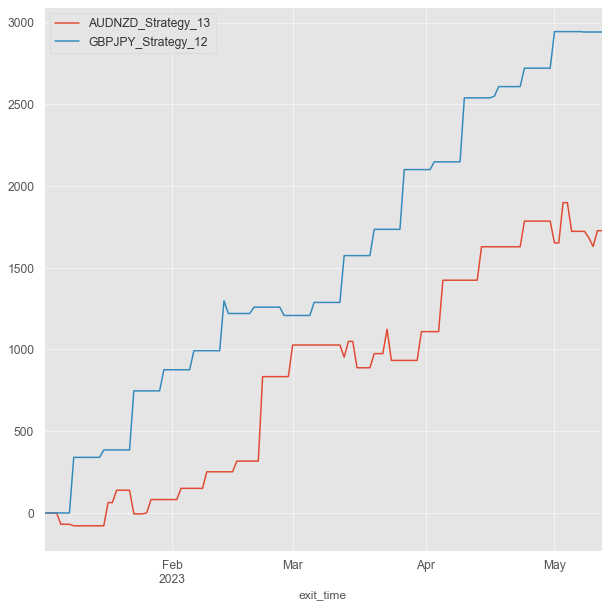

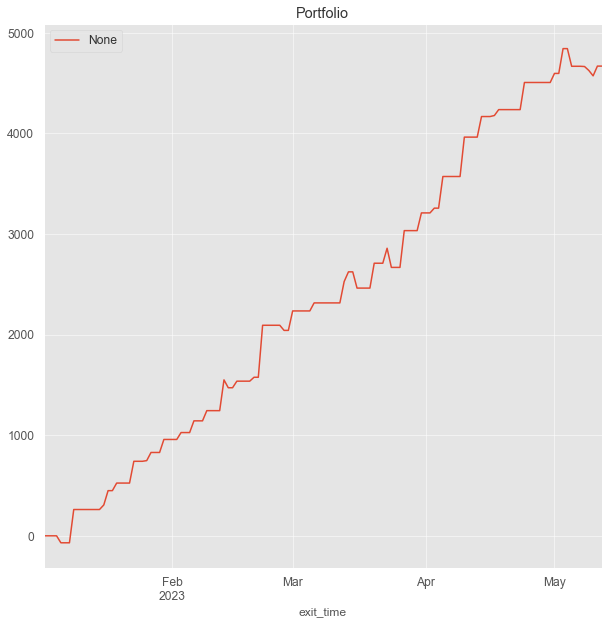

In [132]:
i=0

x=newdf[results.iloc[:,:2].iloc[i].values]
x.iloc[:,1]=x.iloc[:,1]*results.STD.iloc[i]
x=x[x!=0].fillna(0)

x.cumsum().plot(figsize=(10,10))
plt.show()
x.sum(axis=1).cumsum().plot(figsize=(10,10),title="Portfolio")
plt.legend()
plt.show()

In [133]:
stampa = 0
N_SPREAD = 50

today_orders = pd.DataFrame(columns=["pnl","cum","sma","newbal","sng_for_tomorrow","market_1","market_2","market_1_size","market_2_size","v_SMA"])
portfolio = pd.DataFrame()
while True:
    for i in tqdm(range(len(results))):

        x=newdf[results.iloc[:,:2].iloc[i].values]
        x.iloc[:,1]=x.iloc[:,1]*results.STD.iloc[i]
        x=x[x!=0].fillna(0)
                
        if stampa == 1:
            x.cumsum().plot(figsize=(10,10))
            plt.show()
            x.sum(axis=1).cumsum().plot(figsize=(10,10),title="Portfolio")
            plt.legend()
            plt.show()


        a=x.copy().sum(axis=1).to_frame()
        a.columns=(["pnl"])

        a["sng_for_tomorrow"]=1
        a["market_1"] = x.columns[0]
        a["market_2"] = x.columns[1]
        a["market_1_size"]=1
        a["market_2_size"]=results.STD.iloc[i]
        a["v_SMA"]=0
        if stampa == 1:
            a[["pnl","newbal"]].cumsum().plot(figsize=(10,10))
        
        if a.iloc[-1:].sng_for_tomorrow[-1] == 1:
            if (a["market_1"].iloc[0] not in [*today_orders["market_1"].values, *today_orders["market_2"].values])&\
               (a["market_2"].iloc[0] not in [*today_orders["market_1"].values, *today_orders["market_2"].values]):
                    today_orders = pd.concat([today_orders,a.iloc[-1:]])
                    tmp_df = x.sum(axis=1).to_frame()
                    tmp_df.columns = ([a["market_1"].iloc[0]+"_"+a["market_2"].iloc[0]])
                    portfolio=pd.concat([portfolio,tmp_df],axis=1).fillna(0)
   
        if len(today_orders)>=N_SPREAD:
            print("Deviazione Standard")
            display(x.std())
            break
    if len(today_orders)>=N_SPREAD:
        break

Deviazione Standard


AUDJPY_Strategy_21    247.028704
EURUSD_Strategy_10    247.028704
dtype: float64

stampa = 0
N_SPREAD = 50

today_orders = pd.DataFrame(columns=["pnl","cum","sma","newbal","sng_for_tomorrow","market_1","market_2","market_1_size","market_2_size","v_SMA"])
portfolio = pd.DataFrame()
while True:
    for i in tqdm(range(len(results))):

        x=newdf[results.iloc[:,:2].iloc[i].values]
        x=x[x!=0]
        if stampa == 1:
            x.cumsum().plot(figsize=(10,10))
            plt.show()
            x.sum(axis=1).cumsum().plot(figsize=(10,10),title="Portfolio")
            plt.legend()
            plt.show()

        ################################################################################################
        sma_ls=[]
        ks_ls=[]
        for e in tqdm(range(2,40)):
            a=x.copy().sum(axis=1).to_frame()
            a.columns=(["pnl"])
            a["cum"]=a.iloc[:,0].cumsum()
            a["sma"]=a.cum.rolling(e).mean()
            a["newbal"]=0
            a.newbal=np.where(a.cum.shift(1)<a.sma.shift(1),a.iloc[:,0],a.newbal)
            b=a.newbal
            b=b[b!=0].dropna()
            if len(b)>0:
                ks_ls.append(kestner_ratio(b))
                sma_ls.append(e)
            else:
                sma_ls.append(-1)
        v_mean = sma_ls[ks_ls.index(max(ks_ls))]

        a=x.copy().sum(axis=1).to_frame()
        a.columns=(["pnl"])
        a["cum"]=a.iloc[:,0].cumsum()
        a["sma"]=a.cum.rolling(v_mean).mean()
        a["newbal"]=0
        a.newbal=np.where(a.cum.shift(1)<a.sma.shift(1),a.iloc[:,0],a.newbal)
        a["sng_for_tomorrow"]=0
        a["sng_for_tomorrow"]=np.where(a.cum<a.sma,1,a.sng_for_tomorrow)
        a["market_1"] = x.columns[0]
        a["market_2"] = x.columns[1]
        a["market_1_size"]=1#round(float(w.app[w.index==a.market_1.iloc[0]]),2)
        a["market_2_size"]=1#round(float(w.app[w.index==a.market_2.iloc[0]]),2)
        a["v_SMA"]=v_mean
        if stampa == 1:
            a[["pnl","newbal"]].cumsum().plot(figsize=(10,10))
        
        if a.iloc[-1:].sng_for_tomorrow[-1] == 1:
            if (a["market_1"].iloc[0] not in [*today_orders["market_1"].values, *today_orders["market_2"].values])&\
               (a["market_2"].iloc[0] not in [*today_orders["market_1"].values, *today_orders["market_2"].values]):
                    today_orders = pd.concat([today_orders,a.iloc[-1:]])
                    tmp_df = a.newbal.to_frame()
                    tmp_df.columns = ([a["market_1"].iloc[0]+"_"+a["market_2"].iloc[0]])
                    portfolio=pd.concat([portfolio,tmp_df],axis=1).fillna(0)
   
        if len(today_orders)>=N_SPREAD:
            print("Deviazione Standard")
            display(x.std())
            break
    if len(today_orders)>=N_SPREAD:
        break

In [134]:
portfolio.corr()

,AUDNZD_Strategy_13_GBPJPY_Strategy_12,CADJPY_Strategy_18_AUDUSD_Strategy_17,AUDCAD_Strategy_23_CADCHF_Strategy_1,AUDCAD_Strategy_21_AUDUSD_Strategy_7,EURJPY_Strategy_8_CHFJPY_Strategy_10,AUDNZD_Strategy_21_AUDJPY_Strategy_14,EURCAD_Strategy_6_EURGBP_Strategy_17,NZDCAD_Strategy_22_EURAUD_Strategy_6,NZDCAD_Strategy_10_AUDJPY_Strategy_22,AUDNZD_Strategy_19_USDJPY_Strategy_16,GBPAUD_Strategy_0_USDJPY_Strategy_8,USDCAD_Strategy_2_EURJPY_Strategy_5,EURUSD_Strategy_5_AUDCHF_Strategy_9,AUDNZD_Strategy_23_EURCAD_Strategy_1,USDCAD_Strategy_10_AUDCAD_Strategy_17,EURAUD_Strategy_20_USDCAD_Strategy_8,EURUSD_Strategy_11_AUDCHF_Strategy_13,AUDUSD_Strategy_13_GBPUSD_Strategy_0,AUDCHF_Strategy_21_EURGBP_Strategy_13,EURNZD_Strategy_7_CADJPY_Strategy_12,EURGBP_Strategy_2_EURAUD_Strategy_0,GBPAUD_Strategy_16_GBPNZD_Strategy_5,USDJPY_Strategy_14_GBPCAD_Strategy_14,AUDJPY_Strategy_12_GBPUSD_Strategy_5,AUDUSD_Strategy_1_NZDJPY_Strategy_25,NZDCAD_Strategy_13_CADJPY_Strategy_13,USDJPY_Strategy_10_AUDUSD_Strategy_8,GBPNZD_Strategy_7_CADCHF_Strategy_13,AUDNZD_Strategy_25_CHFJPY_Strategy_3,EURAUD_Strategy_4_NZDUSD_Strategy_14,AUDUSD_Strategy_19_CADJPY_Strategy_6,CHFJPY_Strategy_15_AUDNZD_Strategy_7,AUDNZD_Strategy_17_USDCHF_Strategy_7,USDCHF_Strategy_3_NZDCHF_Strategy_21,AUDNZD_Strategy_27_EURUSD_Strategy_3,GBPUSD_Strategy_4_EURGBP_Strategy_12,CHFJPY_Strategy_2_GBPAUD_Strategy_13,AUDJPY_Strategy_11_GBPNZD_Strategy_10,NZDCAD_Strategy_4_CADJPY_Strategy_9,EURUSD_Strategy_12_AUDJPY_Strategy_19,NZDUSD_Strategy_3_NZDCAD_Strategy_24,USDJPY_Strategy_4_NZDCAD_Strategy_26,AUDUSD_Strategy_3_AUDCAD_Strategy_19,GBPUSD_Strategy_6_GBPNZD_Strategy_12,AUDNZD_Strategy_34_NZDJPY_Strategy_10,AUDJPY_Strategy_18_NZDCHF_Strategy_7,EURAUD_Strategy_1_EURGBP_Strategy_20,NZDCAD_Strategy_21_AUDNZD_Strategy_9,CADJPY_Strategy_2_NZDCAD_Strategy_19,AUDJPY_Strategy_21_EURUSD_Strategy_10
AUDNZD_Strategy_13_GBPJPY_Strategy_12,1.000000,0.380955,0.124532,-0.042556,0.565934,0.585269,-0.110501,0.099371,0.495736,0.628929,0.290329,-0.023374,-0.141056,0.281629,-0.059807,-0.002542,-0.067014,-0.062198,-0.131909,0.265377,-0.091570,0.168696,0.326157,0.303214,0.134399,0.046322,0.257932,0.197809,0.501841,0.072393,0.343951,0.343486,0.323876,0.149074,0.100503,0.081778,0.222443,0.085935,-0.019452,0.238709,0.086863,0.181897,0.142107,0.037303,0.165724,0.154652,-0.000635,0.306231,0.190192,0.119146
CADJPY_Strategy_18_AUDUSD_Strategy_17,0.380955,1.000000,0.170013,0.142657,0.535036,0.413715,-0.083947,-0.201446,0.409345,0.366745,0.274087,-0.067725,0.082168,0.165078,0.249106,0.111189,0.098481,0.210926,-0.030270,0.088764,0.096877,0.075061,0.346502,0.216852,0.060961,-0.003617,0.359004,0.025397,0.123496,-0.175658,0.675193,0.009768,0.008718,0.107316,0.175365,-0.002991,0.200897,0.069994,-0.134712,-0.060570,0.234667,0.093027,0.221820,-0.111925,0.168541,0.205347,0.146957,0.127166,0.314792,-0.071032
AUDCAD_Strategy_23_CADCHF_Strategy_1,0.124532,0.170013,1.000000,0.346285,-0.019798,0.112058,0.064826,0.095164,0.039475,0.086865,-0.063023,-0.038380,0.307566,0.211899,0.390491,0.101758,0.165470,0.214584,0.134640,0.068868,0.072800,0.152890,-0.068876,0.060879,0.026309,0.279451,-0.033901,0.234901,0.080034,-0.113108,0.164527,0.144600,0.102006,0.190431,0.237068,-0.172231,-0.181389,0.108864,-0.131340,0.044390,0.247125,0.144113,0.278967,0.029568,0.040392,0.224939,0.158028,0.167674,0.252923,0.016899
AUDCAD_Strategy_21_AUDUSD_Strategy_7,-0.042556,0.142657,0.346285,1.000000,-0.097869,0.010841,0.083760,-0.097216,-0.085100,0.016555,0.043840,0.102161,0.710736,0.141850,0.808144,0.120770,0.534474,0.403718,0.319256,0.080872,-0.023251,0.126953,-0.101408,0.091285,0.423224,0.271688,-0.054785,-0.108306,0.164530,-0.008262,0.098658,0.137679,0.007835,0.048247,0.232163,-0.025628,-0.164211,0.206321,0.029305,0.097706,0.331446,0.082656,0.418367,0.092990,-0.092167,0.273360,0.004793,0.337966,0.259569,0.136676
EURJPY_Strategy_8_CHFJPY_Strategy_10,0.565934,0.535036,-0.019798,-0.097869,1.000000,0.446246,-0.101379,-0.039389,0.410196,0.313806,0.344946,-0.094

In [135]:
backup = portfolio.copy()

In [136]:
w=portfolio.std().to_frame("STD")
w["STD_MAX"] = w.STD.max()
w["peso"]=round((w.STD_MAX/w.STD),2)
w

,STD,STD_MAX,peso
AUDNZD_Strategy_13_GBPJPY_Strategy_12,101.684549,355.318412,3.49
CADJPY_Strategy_18_AUDUSD_Strategy_17,192.878515,355.318412,1.84
AUDCAD_Strategy_23_CADCHF_Strategy_1,196.322959,355.318412,1.81
AUDCAD_Strategy_21_AUDUSD_Strategy_7,160.419616,355.318412,2.21
EURJPY_Strategy_8_CHFJPY_Strategy_10,208.435275,355.318412,1.70
AUDNZD_Strategy_21_AUDJPY_Strategy_14,152.627904,355.318412,2.33
EURCAD_Strategy_6_EURGBP_Strategy_17,113.807303,355.318412,3.12
NZDCAD_Strategy_22_EURAUD_Strategy_6,231.049079,355.318412,1.54
NZDCAD_Strategy_10_AUDJPY_Strategy_22,141.945097,355.318412,2.50
AUDNZD_Strategy_19_USDJPY_Strategy_16,120.564881,355.318412,2.95


In [137]:
for e in portfolio.columns:
    W = float(w.peso[w.index==e])
    portfolio[e]=portfolio[e]*W

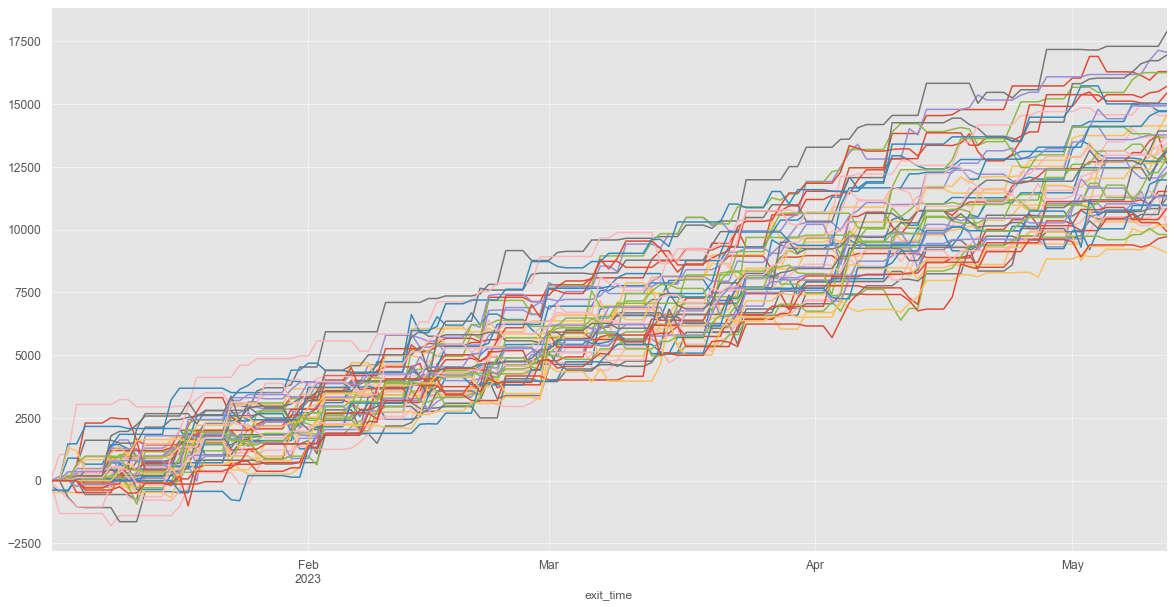

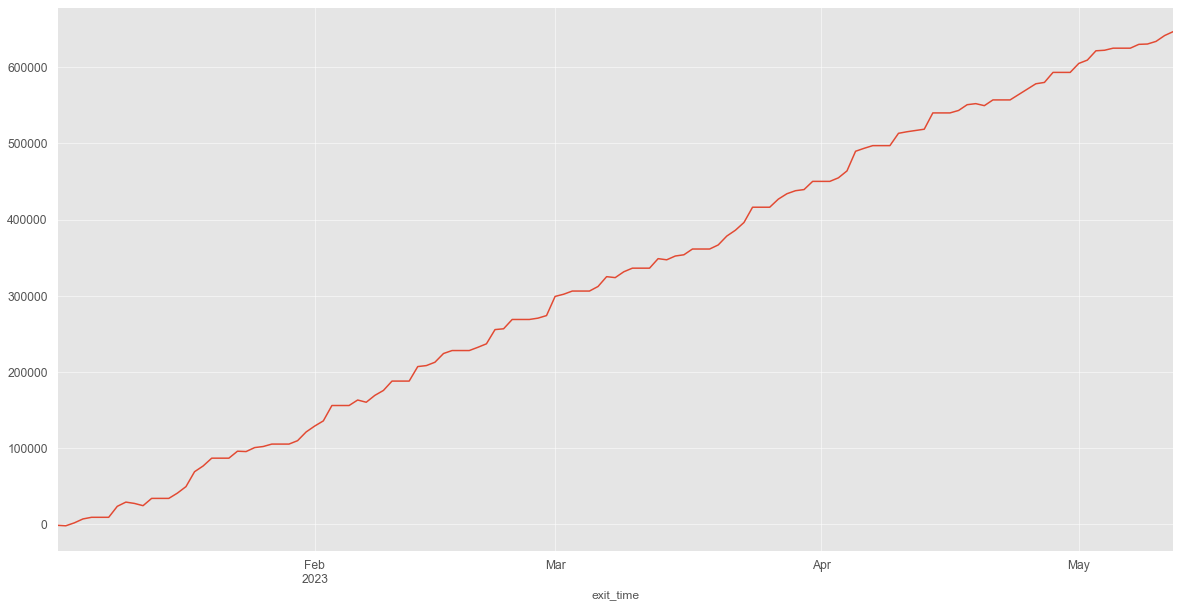

In [138]:
portfolio.cumsum().plot(figsize=(20,10),grid=True,legend=None)
plt.show()
portfolio.sum(axis=1).cumsum().plot(figsize=(20,10),grid=True)
plt.show()

In [139]:
portfolio.sum(axis=1).describe()

count      131.000000
mean      4934.944011
std       6008.081100
min      -2944.042713
25%          0.000000
50%       3498.636980
75%       7591.050697
max      25778.696043
dtype: float64

In [140]:
portfolio.sum(axis=1).idxmin()

Timestamp('2023-01-12 00:00:00', freq='D')

In [141]:
today_orders["peso"] = 0
for e in range(len(today_orders)):
    x=today_orders.iloc[e].market_1+"_"+today_orders.iloc[e].market_2
    W = float(w.peso[w.index==x])
    today_orders["peso"].iloc[e]=W

In [142]:
today_orders["market_1_RE_size"] = today_orders.market_1_size * today_orders.peso
today_orders["market_2_RE_size"] = round((today_orders.market_2_size * today_orders.peso),2)

In [143]:
today_orders

,pnl,cum,sma,newbal,sng_for_tomorrow,market_1,market_2,market_1_size,market_2_size,v_SMA,peso,market_1_RE_size,market_2_RE_size
2023-05-12,0.000000,NaN,NaN,NaN,1,AUDNZD_Strategy_13,GBPJPY_Strategy_12,1,0.311229,0,3.49,3.49,1.09
2023-05-12,253.994741,NaN,NaN,NaN,1,CADJPY_Strategy_18,AUDUSD_Strategy_17,1,0.592062,0,1.84,1.84,1.09
2023-05-12,-42.973490,NaN,NaN,NaN,1,AUDCAD_Strategy_23,CADCHF_Strategy_1,1,1.824736,0,1.81,1.81,3.30
2023-05-12,265.236812,NaN,NaN,NaN,1,AUDCAD_Strategy_21,AUDUSD_Strategy_7,1,1.504203,0,2.21,2.21,3.32
2023-05-12,0.000000,NaN,NaN,NaN,1,EURJPY_Strategy_8,CHFJPY_Strategy_10,1,1.196021,0,1.70,1.7,2.03
2023-05-12,0.000000,NaN,NaN,NaN,1,AUDNZD_Strategy_21,AUDJPY_Strategy_14,1,0.828212,0,2.33,2.33,1.93
2023-05-12,0.000000,NaN,NaN,NaN,1,EURCAD_Strategy_6,EURGBP_Strategy_17,1,0.564631,0,3.12,3.12,1.76
2023-05-12,-730.487735,NaN,NaN,NaN,1,NZDCAD_Strategy_22,EURAUD_Strategy_6,1,1.229001,0,1.54,1.54,1.89
2023-05-12,0.000000,NaN,NaN,NaN,1,NZDCAD_Strategy_10,AUDJPY_Strategy_22,1,0.804399,0,2.50,2.5,2.01
2023-05-12,0.000000,NaN,NaN,NaN,1,AUDNZD_Strategy_19,USDJPY_Strategy_16,1,0.786048,0,2.95,2.95,2.32


In [144]:
strategy_ok = today_orders[["market_1","market_1_RE_size"]]
strategy_ok.columns=(["strategy","Size"])
strategy_ok

,strategy,Size
2023-05-12,AUDNZD_Strategy_13,3.49
2023-05-12,CADJPY_Strategy_18,1.84
2023-05-12,AUDCAD_Strategy_23,1.81
2023-05-12,AUDCAD_Strategy_21,2.21
2023-05-12,EURJPY_Strategy_8,1.7
2023-05-12,AUDNZD_Strategy_21,2.33
2023-05-12,EURCAD_Strategy_6,3.12
2023-05-12,NZDCAD_Strategy_22,1.54
2023-05-12,NZDCAD_Strategy_10,2.5
2023-05-12,AUDNZD_Strategy_19,2.95


In [145]:
strategy_ok1 = today_orders[["market_2","market_2_RE_size"]]
strategy_ok1.columns=(["strategy","Size"])
strategy_ok1

,strategy,Size
2023-05-12,GBPJPY_Strategy_12,1.09
2023-05-12,AUDUSD_Strategy_17,1.09
2023-05-12,CADCHF_Strategy_1,3.30
2023-05-12,AUDUSD_Strategy_7,3.32
2023-05-12,CHFJPY_Strategy_10,2.03
2023-05-12,AUDJPY_Strategy_14,1.93
2023-05-12,EURGBP_Strategy_17,1.76
2023-05-12,EURAUD_Strategy_6,1.89
2023-05-12,AUDJPY_Strategy_22,2.01
2023-05-12,USDJPY_Strategy_16,2.32


In [146]:
strategy = pd.concat([strategy_ok,strategy_ok1])
strategy

,strategy,Size
2023-05-12,AUDNZD_Strategy_13,3.49
2023-05-12,CADJPY_Strategy_18,1.84
2023-05-12,AUDCAD_Strategy_23,1.81
2023-05-12,AUDCAD_Strategy_21,2.21
2023-05-12,EURJPY_Strategy_8,1.7
2023-05-12,AUDNZD_Strategy_21,2.33
2023-05-12,EURCAD_Strategy_6,3.12
2023-05-12,NZDCAD_Strategy_22,1.54
2023-05-12,NZDCAD_Strategy_10,2.5
2023-05-12,AUDNZD_Strategy_19,2.95


In [147]:
import os 
os.chdir(r"C:\Users\Administrator\fAInance")
strategy.to_csv("strategy_ok.csv")

In [148]:
strategy

,strategy,Size
2023-05-12,AUDNZD_Strategy_13,3.49
2023-05-12,CADJPY_Strategy_18,1.84
2023-05-12,AUDCAD_Strategy_23,1.81
2023-05-12,AUDCAD_Strategy_21,2.21
2023-05-12,EURJPY_Strategy_8,1.7
2023-05-12,AUDNZD_Strategy_21,2.33
2023-05-12,EURCAD_Strategy_6,3.12
2023-05-12,NZDCAD_Strategy_22,1.54
2023-05-12,NZDCAD_Strategy_10,2.5
2023-05-12,AUDNZD_Strategy_19,2.95


In [116]:
strategy = strategy.sort_values("strategy")
strategy["asset"] = [e.split("_")[0] for e in strategy.strategy if e.split("_")[0]]

In [117]:
strategy.groupby("asset").count()

,strategy,Size
asset,,
AUDCAD,5,5
AUDCHF,3,3
AUDJPY,6,6
AUDNZD,9,9
AUDUSD,7,7
CADCHF,2,2
CADJPY,5,5
CHFJPY,4,4
EURAUD,5,5


In [118]:
import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
plt.style.use("ggplot")

def my_drawdown(series):
    equity = series.cumsum()
    maxvalue = equity.expanding(0).max()
    drawdown = equity - maxvalue
    drawdown_series = pd.Series(drawdown, index = equity.index)
    return drawdown_series

def my_max_draw_down(series):
    dd = my_drawdown(series)
    return abs(round(dd.min(),2))

def my_ret_dd(series):
    return round((series.sum()/abs(my_max_draw_down(series))),2)

def my_sharpe_ratio(series):
    equity = series.cumsum()
    netprofit = equity[-1]
    std = equity.std()
    if std != 0:
        return round(netprofit / std,2)
    else:
        return np.inf
    
def my_consec_win(series):
    data = series.to_frame()
    data[data>0]="TMP"
    data[data!="TMP"]=0
    data[data=="TMP"]=1
    data.columns=(["result"])
    data['start_of_streak'] = data['result'].ne(data['result'].shift())
    data['streak_id'] = data.start_of_streak.cumsum()
    data['streak_counter'] = data.groupby('streak_id').cumcount() + 1
    streaks = pd.concat([series, data['streak_counter']], axis=1)
    return streaks[streaks.iloc[:,0]>0].streak_counter.max()

def my_consec_loss(series):
    data = series.to_frame()
    data[data>0]="TMP"
    data[data!="TMP"]=0
    data[data=="TMP"]=1
    data.columns=(["result"])
    data['start_of_streak'] = data['result'].ne(data['result'].shift())
    data['streak_id'] = data.start_of_streak.cumsum()
    data['streak_counter'] = data.groupby('streak_id').cumcount() + 1
    streaks = pd.concat([series, data['streak_counter']], axis=1)
    return streaks[streaks.iloc[:,0]<0].streak_counter.max()

def my_mean_loss(series):
    return (round(series[series<0].dropna().mean(),2))*(-1)

def my_mean_win(series):
    return round(series[series>0].dropna().mean(),2)

def my_avg_trade(series):
    return round(series.mean(),2)


import MetaTrader5 as mt5
from datetime import datetime
import pandas as pd
import numpy as np
from datetime import timedelta

ls_mercati=["AUDCAD","AUDCHF","AUDJPY","AUDNZD","AUDUSD","CADCHF","CADJPY","CHFJPY","EURAUD","EURCAD","EURCHF","EURGBP","EURJPY",\
                "EURNZD","EURUSD","GBPAUD","GBPCAD","GBPCHF","GBPJPY","GBPNZD","GBPUSD","NZDCAD","NZDCHF","NZDJPY","NZDUSD","USDCAD",\
                "USDCHF","USDJPY"]

pd.set_option('display.max_columns', 500) # number of columns to be displayed
pd.set_option('display.width', 1500)      # max table width to display
# display data on the MetaTrader 5 package
print("MetaTrader5 package author: ",mt5.__author__)
print("MetaTrader5 package version: ",mt5.__version__)
print()

path = (r"C:\Program Files\AMP Global (EU) MT5 Terminal 1\terminal64.exe")

# establish connection to the MetaTrader 5 terminal
if not mt5.initialize(path):
    print("initialize() failed, error code =",mt5.last_error())
    quit()
 
# get the number of deals in history
from_date=datetime(2020,1,1)
to_date=datetime.now()+timedelta(days=1)
 
    
# get deals for symbols whose names contain neither "EUR" nor "GBP"
deals = mt5.history_deals_get(from_date, to_date, group="**")
if deals == None:
    print("No deals, error code={}".format(mt5.last_error()))
elif len(deals) > 0:
    # display these deals as a table using pandas.DataFrame
    df=pd.DataFrame(list(deals),columns=deals[0]._asdict().keys())
    df['time'] = pd.to_datetime(df['time'], unit='s')
df.time_msc=pd.to_datetime(df.time_msc, unit='ms')
print("")

# shut down connection to the MetaTrader 5 terminal
mt5.shutdown()
data=df[["time","type","symbol","profit","comment"]]
data.set_index(["time"],inplace=True)
data.index=pd.to_datetime(data.index)
ls_mercati_real = list(set(data.symbol))
data

MetaTrader5 package author:  MetaQuotes Software Corp.
MetaTrader5 package version:  5.0.33




,type,symbol,profit,comment
time,,,,
2023-04-26 00:04:47,2,,1000000.00,
2023-04-26 02:00:14,1,AUDJPY,0.00,AUDJPY_19_short
2023-04-26 02:00:15,1,AUDJPY,0.00,AUDJPY_21_short
2023-04-26 02:00:17,1,AUDNZD,0.00,AUDNZD_19_short
2023-04-26 02:00:18,1,NZDCAD,0.00,NZDCAD_13_short
2023-04-26 03:00:03,1,EURCHF,0.00,EURCHF_21_short
2023-04-26 03:00:05,0,GBPAUD,0.00,GBPAUD_16_long
2023-04-26 03:00:06,0,NZDJPY,0.00,NZDJPY_6_long
2023-04-26 03:00:08,0,NZDJPY,0.00,NZDJPY_10_long


In [119]:
data.type[data.type==1]="short"
data.type[data.type==0]="long"

In [120]:
data=data[data.profit!=0].iloc[1:]

In [121]:
data[data.type=="short"].type.count()

192

In [126]:
data.iloc[1:].groupby(["symbol"]).profit.sum()

symbol
AUDCAD    2280.52
AUDCHF   -2337.75
AUDJPY    9917.95
AUDNZD    1513.14
AUDUSD    -243.99
CADCHF     239.34
CADJPY    7624.70
CHFJPY    1141.65
EURAUD    1995.92
EURCAD    -823.06
EURCHF   -5564.60
EURGBP    2329.06
EURJPY    3360.19
EURNZD   -2014.73
EURUSD    2118.84
GBPAUD    2169.37
GBPCAD    -286.38
GBPCHF    -536.11
GBPJPY     699.25
GBPNZD    -741.61
GBPUSD     -53.07
NZDCAD   -1598.57
NZDCHF   -1990.49
NZDJPY     115.10
NZDUSD   -1487.15
USDCAD     907.29
USDCHF   -4728.15
USDJPY    3318.11
Name: profit, dtype: float64

In [114]:
data[(data.symbol=="EURJPY")]

,type,symbol,profit,comment
time,,,,
2023-05-01 09:00:10,short,EURJPY,647.77,
2023-05-01 17:00:04,short,EURJPY,-26.47,
2023-05-01 21:00:11,short,EURJPY,134.38,
2023-05-01 22:38:10,short,EURJPY,18.43,
2023-05-02 04:00:08,short,EURJPY,64.99,
2023-05-04 06:00:05,long,EURJPY,-205.60,
2023-05-04 11:48:58,long,EURJPY,648.42,
2023-05-04 16:00:02,long,EURJPY,273.40,
2023-05-04 18:00:09,long,EURJPY,1325.10,


<AxesSubplot:xlabel='time'>

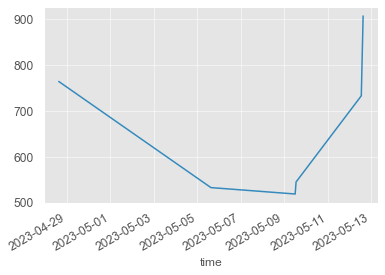

In [107]:
data.profit[(data.symbol=="USDCAD")&(data.type=="long")].cumsum().plot()
data.profit[(data.symbol=="USDCAD")&(data.type=="short")].cumsum().plot()

In [61]:
data.iloc[1:].groupby("symbol").profit.sum().sum()

16923.310000000005

<AxesSubplot:xlabel='time'>

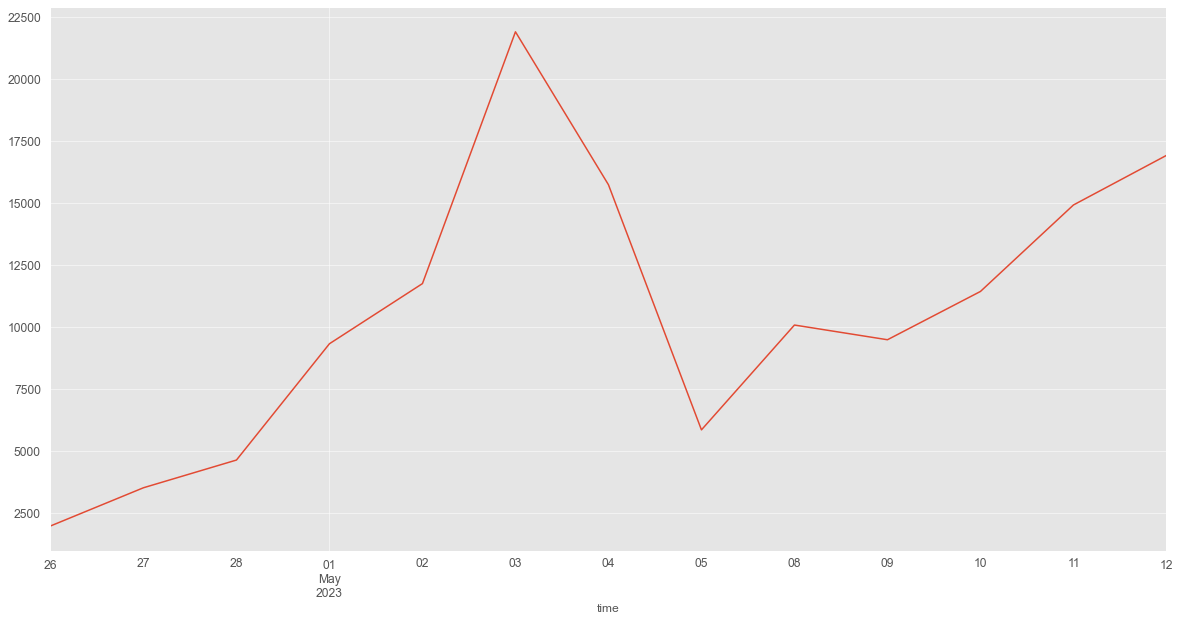

In [67]:
data.iloc[1:].profit.resample("B").sum().cumsum().plot(figsize=(20,10),grid=True)